In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/mnt/antares_raid/home/bramantyos/codes/multilang_timescale


In [4]:
import json

import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns

from src.settings import TrainerSetting

from src.utils.utils import get_surface_dict, get_valid_result
from src.utils.meta import read_result_meta

from src.utils.plot import (
    config_plotting,
    figsize_dict,
    h_cbar_figsize_dict,
    v_cbar_figsize_dict,
    plot_simple_flatmap
)


In [5]:
surfaces_json = ".temp/fmri/bling/surfaces.json"
surfaces_dir = "/mnt/raid/bling/share/pycortex_store"

result_meta_dir = ".temp/result_meta/bling"

result_metric = "r2"

alpha = 0.05

plotting_context='paper'

analysis_name = "sensory_prediction"

figsize_type = 'full'

In [6]:
subject_ids = ["COL", "GFW", "TYE"]

config_plotting(context=plotting_context)

figsize = figsize_dict[figsize_type]
v_cbar_figsize = v_cbar_figsize_dict[figsize_type]
h_cbar_figsize = h_cbar_figsize_dict[figsize_type]

In [7]:
def get_stats(subject_id: str):
    if subject_id == "COL":
        en_feature_config = f".temp/config/bling/feature/sensory_feature_en.json"
        zh_feature_config = f".temp/config/bling/feature/sensory_feature_zh.json"

    else:
        en_feature_config = f".temp/config/bling/feature/{subject_id}/sensory_feature_en.json"
        zh_feature_config = f".temp/config/bling/feature/{subject_id}/sensory_feature_zh.json"
        
    trainer_config = ".temp/config/bling/train/trainer_lowlevel_stepwise.json"

    en_subject_config = f".temp/config/bling/subject/{subject_id}_en.json"
    zh_subject_config = f".temp/config/bling/subject/{subject_id}_zh.json"  

    en_meta_df = read_result_meta(result_meta_dir,
                                    trainer_setting_path=trainer_config,
                                    subject_setting_path=en_subject_config,
                                    feature_setting_path=en_feature_config,)

    zh_meta_df = read_result_meta(result_meta_dir,
                                    trainer_setting_path=trainer_config,
                                    subject_setting_path=zh_subject_config,
                                    feature_setting_path=zh_feature_config,)
    
    
    en_config = en_meta_df.iloc[0].to_dict()
    zh_config = zh_meta_df.iloc[0].to_dict()
    
    # loading stats
    en_stat = en_config["stats_path"]
    en_stat = np.load(en_stat)

    zh_stat = zh_config["stats_path"]
    zh_stat = np.load(zh_stat)
    
    keyword = f"test_joint_{result_metric}_score_mask"

    en_stat = get_valid_result(en_stat, keyword, metric=result_metric, alpha=alpha)
    zh_stat = get_valid_result(zh_stat, keyword, metric=result_metric, alpha=alpha)

    if result_metric == 'r2':
        en_stat = np.maximum(0, np.sqrt(en_stat))
        zh_stat = np.maximum(0, np.sqrt(zh_stat))        
    
    return {
        'en': en_stat,
        'zh': zh_stat
    }

In [8]:
vmin = 0
vmax = 0
stats = {}
for id in subject_ids:
    
    stats[id] = get_stats(id)

    en_score = stats[id]['en']
    zh_score = stats[id]['zh']
    
    # drop nan
    en_score = en_score[~np.isnan(en_score)]
    zh_score = zh_score[~np.isnan(zh_score)]
    
    # computing vmin vmax
    vmin = min(vmin, np.min(en_score), np.min(zh_score))
    vmax = max(vmax, np.max(en_score), np.max(zh_score))

/tmp/ipykernel_1721630/3136447518.py:42: RuntimeWarning: invalid value encountered in sqrt
  en_stat = np.maximum(0, np.sqrt(en_stat))
/tmp/ipykernel_1721630/3136447518.py:43: RuntimeWarning: invalid value encountered in sqrt
  zh_stat = np.maximum(0, np.sqrt(zh_stat))
/tmp/ipykernel_1721630/3136447518.py:42: RuntimeWarning: invalid value encountered in sqrt
  en_stat = np.maximum(0, np.sqrt(en_stat))


plotting COL en
item_to_outline: fill path has no segments!
item_to_outline: fill path has no segments!
Background RRGGBBAA: ffffff00
Area 0:0:2131.07:1024 exported to 2131 x 1024 pixels (96 dpi)


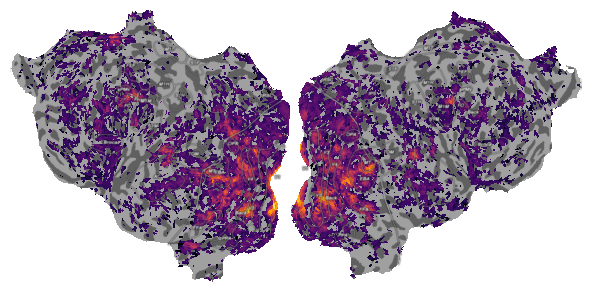

plotting COL zh
item_to_outline: fill path has no segments!
item_to_outline: fill path has no segments!
Background RRGGBBAA: ffffff00
Area 0:0:2131.07:1024 exported to 2131 x 1024 pixels (96 dpi)


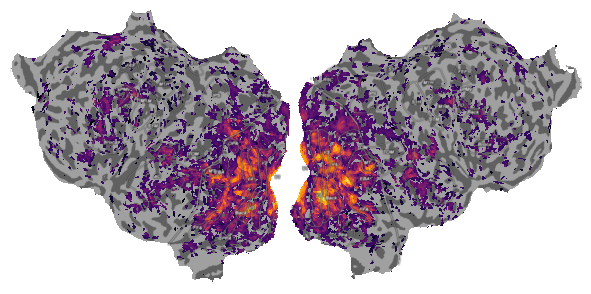

plotting GFW en
Background RRGGBBAA: ffffff00
Area 0:0:2013.43:1024 exported to 2013 x 1024 pixels (96 dpi)


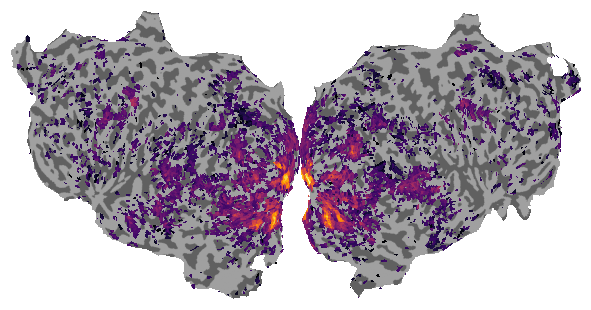

plotting GFW zh
Background RRGGBBAA: ffffff00
Area 0:0:2013.43:1024 exported to 2013 x 1024 pixels (96 dpi)


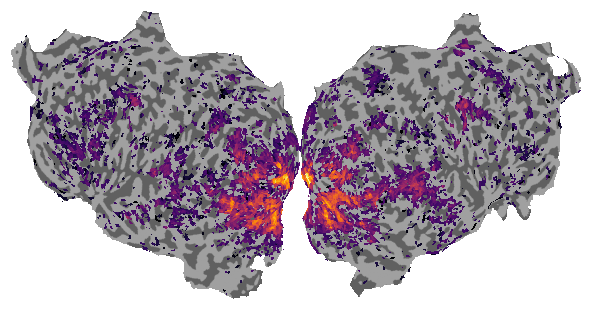

plotting TYE en
Background RRGGBBAA: ffffff00
Area 0:0:2025.18:1024 exported to 2025 x 1024 pixels (96 dpi)


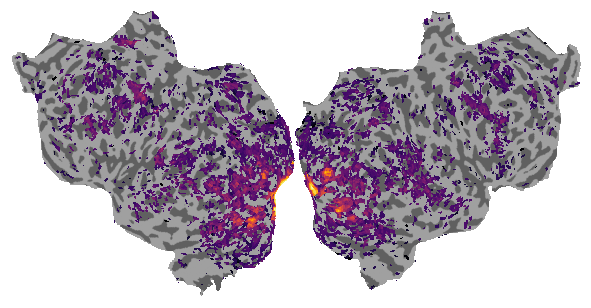

plotting TYE zh
Background RRGGBBAA: ffffff00
Area 0:0:2025.18:1024 exported to 2025 x 1024 pixels (96 dpi)


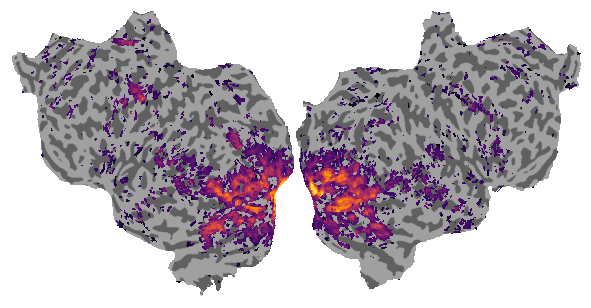

In [9]:
for id in subject_ids:
    surface_dict = get_surface_dict(id)
    for lang in ['en', 'zh']:
        print(f"plotting {id} {lang}")
        score = stats[id][lang]
        
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        plot_simple_flatmap(
            score,
            surface_dict,
            vmin=vmin,
            vmax=vmax,
            cmap='inferno',
            ax = ax,
        )
        
        save_path=f".temp/image/{analysis_name}/{id}/{lang}_flatmap.png"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)
        plt.show()

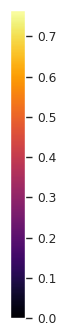

In [13]:
# plot cbar vertical 
fig, ax = plt.subplots(1, 1, figsize=figsize)

cmap = plt.get_cmap('inferno')
norm = plt.Normalize(vmin, vmax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=ax)

ax.remove()


save_fn = f".temp/image/{analysis_name}/cbar_vertical.png"

os.makedirs(os.path.dirname(save_fn), exist_ok=True)

plt.savefig(save_fn, dpi=300)

plt.show()


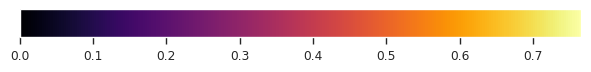

In [14]:
# plot cbar horizontal
fig, ax = plt.subplots(1, 1, figsize=figsize)

cmap = plt.get_cmap('inferno')
norm = plt.Normalize(vmin, vmax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=ax, orientation='horizontal')

ax.remove()

plt.tight_layout()

save_fn = f".temp/image/{analysis_name}/cbar_horizontal.png"

os.makedirs(os.path.dirname(save_fn), exist_ok=True)

plt.savefig(save_fn, dpi=300)